# Lab | Customer Analysis Final Round

For this lab, we still keep using the marketing_customer_analysis.csv file that you can find in the files_for_lab folder.
It's time to put it all together. Remember the previous rounds and follow the steps as shown in previous lectures.

## 01 - Problem (case study)

Goal.
The objective of this data is to understand customer demographics and buying behavior. Ultimately, we would like to predict the total claim amount that the company can expect to receive from a customer.

Data Description.
The data is in a csv file 

## 02 - Getting Data

In [1]:
# Import the necessary libraries.
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score

### Read the .csv file

In [2]:
data = pd.read_csv('./files_for_lab/csv_files/marketing_customer_analysis.csv')

## 03 - Cleaning/Wrangling

### Initial clean (Change headers names)

In [3]:
data = data.drop_duplicates() # Drop duplicates 
data.columns = data.columns.str.lower().str.strip().str.replace(' ', '_') # Standardize column names
data = data.reindex(sorted(data.columns), axis=1).reset_index(drop = True) # Sort columns alphabetically

### Deal with NaN values.

In [4]:
# Dealing with data types (trying to cast to numerical where possible)
def cast_column(col):
    try:
        col = col.astype(int) # Try to cast the column to integer
    except ValueError:
        try:
            col = col.astype(float) # If it fails, try to cast the column to float
        except ValueError:
            pass # If it fails again, leave the column as object
    return col
default_dtypes = data.dtypes # Store the default dtypes 
suggested_casts = data.apply(cast_column) # Apply the function to each column 

# Dealing with null values 
def clean_data(data):
    null_perc = data.isnull().sum() / len(data) * 100 # Calculate the percentage of null values in each column 
    for column in null_perc.index:
        if null_perc[column] > 80: # If the percentage is greater than 90%
            data = data.drop(columns = column) # Drop the column
        elif 30 < null_perc[column] <= 80: # If the percentage is between 50% and 90%
            if data[column].dtype != 'object': # If the column is numeric
                data[column] = data[column].fillna(data[column].median()) # Fill the null values with the median of the column
            else: # If the column is categorical
                data[column] = data[column].fillna(data[column].mode()[0]) # Fill the null values with the mode of the column
        else: # If the percentage can't be calculated, leave the column value as it is
            continue
    return data # Return the dataframe
data = clean_data(data) # Clean the dataframe
data = data.dropna() # Drop the remaining null values

### Categorical Features & Numerical Features.

In [5]:
numerical = data.select_dtypes(include=np.number) # Select numerical columns 
categoricals = data.select_dtypes(include=object) # Select categorical columns

### Exploratory Data Analysis (EDA)

,coverage,customer,customer_lifetime_value,education,effective_to_date,employmentstatus,gender,income,location_code,marital_status,...,number_of_policies,policy,policy_type,renew_offer_type,response,sales_channel,state,total_claim_amount,vehicle_class,vehicle_size
12,Premium,DP39365,8798.797003,Master,2/6/11,Employed,M,77026,Urban,Married,...,3,Corporate L1,Corporate Auto,Offer2,No,Agent,California,472.029737,Four-Door Car,Medsize
13,Basic,SJ95423,8819.018934,High School or Below,1/10/11,Employed,M,99845,Suburban,Married,...,8,Corporate L3,Corporate Auto,Offer2,Yes,Branch,Arizona,528.000000,SUV,Medsize
14,Basic,IL66569,5384.431665,College,1/18/11,Employed,M,83689,Urban,Single,...,8,Corporate L3,Corporate Auto,Offer4,No,Call Center,California,307.139132,Four-Door Car,Medsize
15,Basic,BW63560,7463.139377,Bachelor,1/17/11,Employed,F,24599,Rural,Married,...,2,Corporate L2,Corporate Auto,Offer2,No,Branch,Oregon,42.920271,Four-Door Car,Medsize
28,Premium,GE62437,12902.560140,College,2/2/11,Employed,F,86584,Suburban,Single,...,2,Personal L3,Personal Auto,Offer1,No,Call Center,Arizona,532.800000,Four-Door Car,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9087,Premium,GV76798,4781.821034,Master,1/24/11,Employed,F,30361,Urban,Married,...,1,Personal L2,Personal Auto,Offer2,No,Branch,California,373.289571,Four-Door Car,Medsize
9092,Basic,CO91673,4547.321823,Bachelor,2/14/11,Medical Leave,F,29031,Suburban,Married,...,3,Personal L2,Personal Auto,Offer2,No,Agent,California,292.800000,Four-Door Car,Medsize
9105,Extended,IK96366,5551.398167,College,2/22/11,Employed,M,36918,Suburban,Divorced,...,3,Personal L1,Personal Auto,Offer1,No,Branch,California,364.800000,Two-Door Car,Medsize
9111,Basic,IJ25462,2845.520933,Bachelor,2/7/11,Employed,M,86631,Suburban,Divorced,...,1,Personal L2,Personal Auto,Offer3,No,Agent,California,400.832857,Four-Door Car,Small


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
count,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000
mean,8028.476857,50790.610519,93.331912,15.206823,47.218905,1.850036,2.970149,370.767000
std,6997.825496,23931.602457,34.124969,10.301045,27.452048,1.119260,2.394984,251.954824
min,2119.894333,10105.000000,61.000000,0.000000,0.000000,1.000000,1.000000,0.517753
25%,4239.148172,29423.500000,68.000000,6.000000,23.500000,1.000000,1.000000,209.184753
50%,5837.528088,47406.000000,83.000000,14.000000,46.000000,1.000000,2.000000,336.000000
75%,8804.846277,70723.500000,109.000000,24.000000,70.000000,3.000000,4.000000,489.600000
max,67907.270500,99961.000000,297.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
customer_lifetime_value,1.000000,0.024366,0.396262,0.011517,0.009418,-0.036343,0.021955,0.226451
income,0.024366,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
monthly_premium_auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
months_since_last_claim,0.011517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
months_since_policy_inception,0.009418,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
number_of_open_complaints,-0.036343,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
number_of_policies,0.021955,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
total_claim_amount,0.226451,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


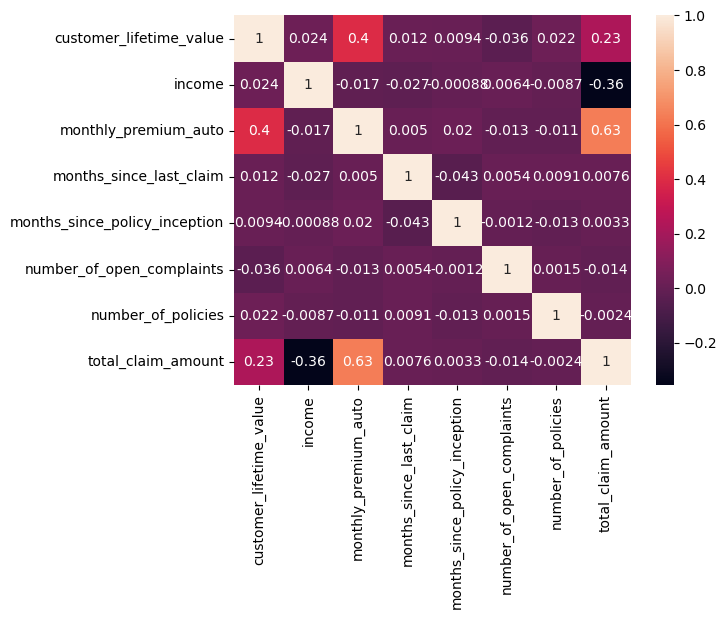

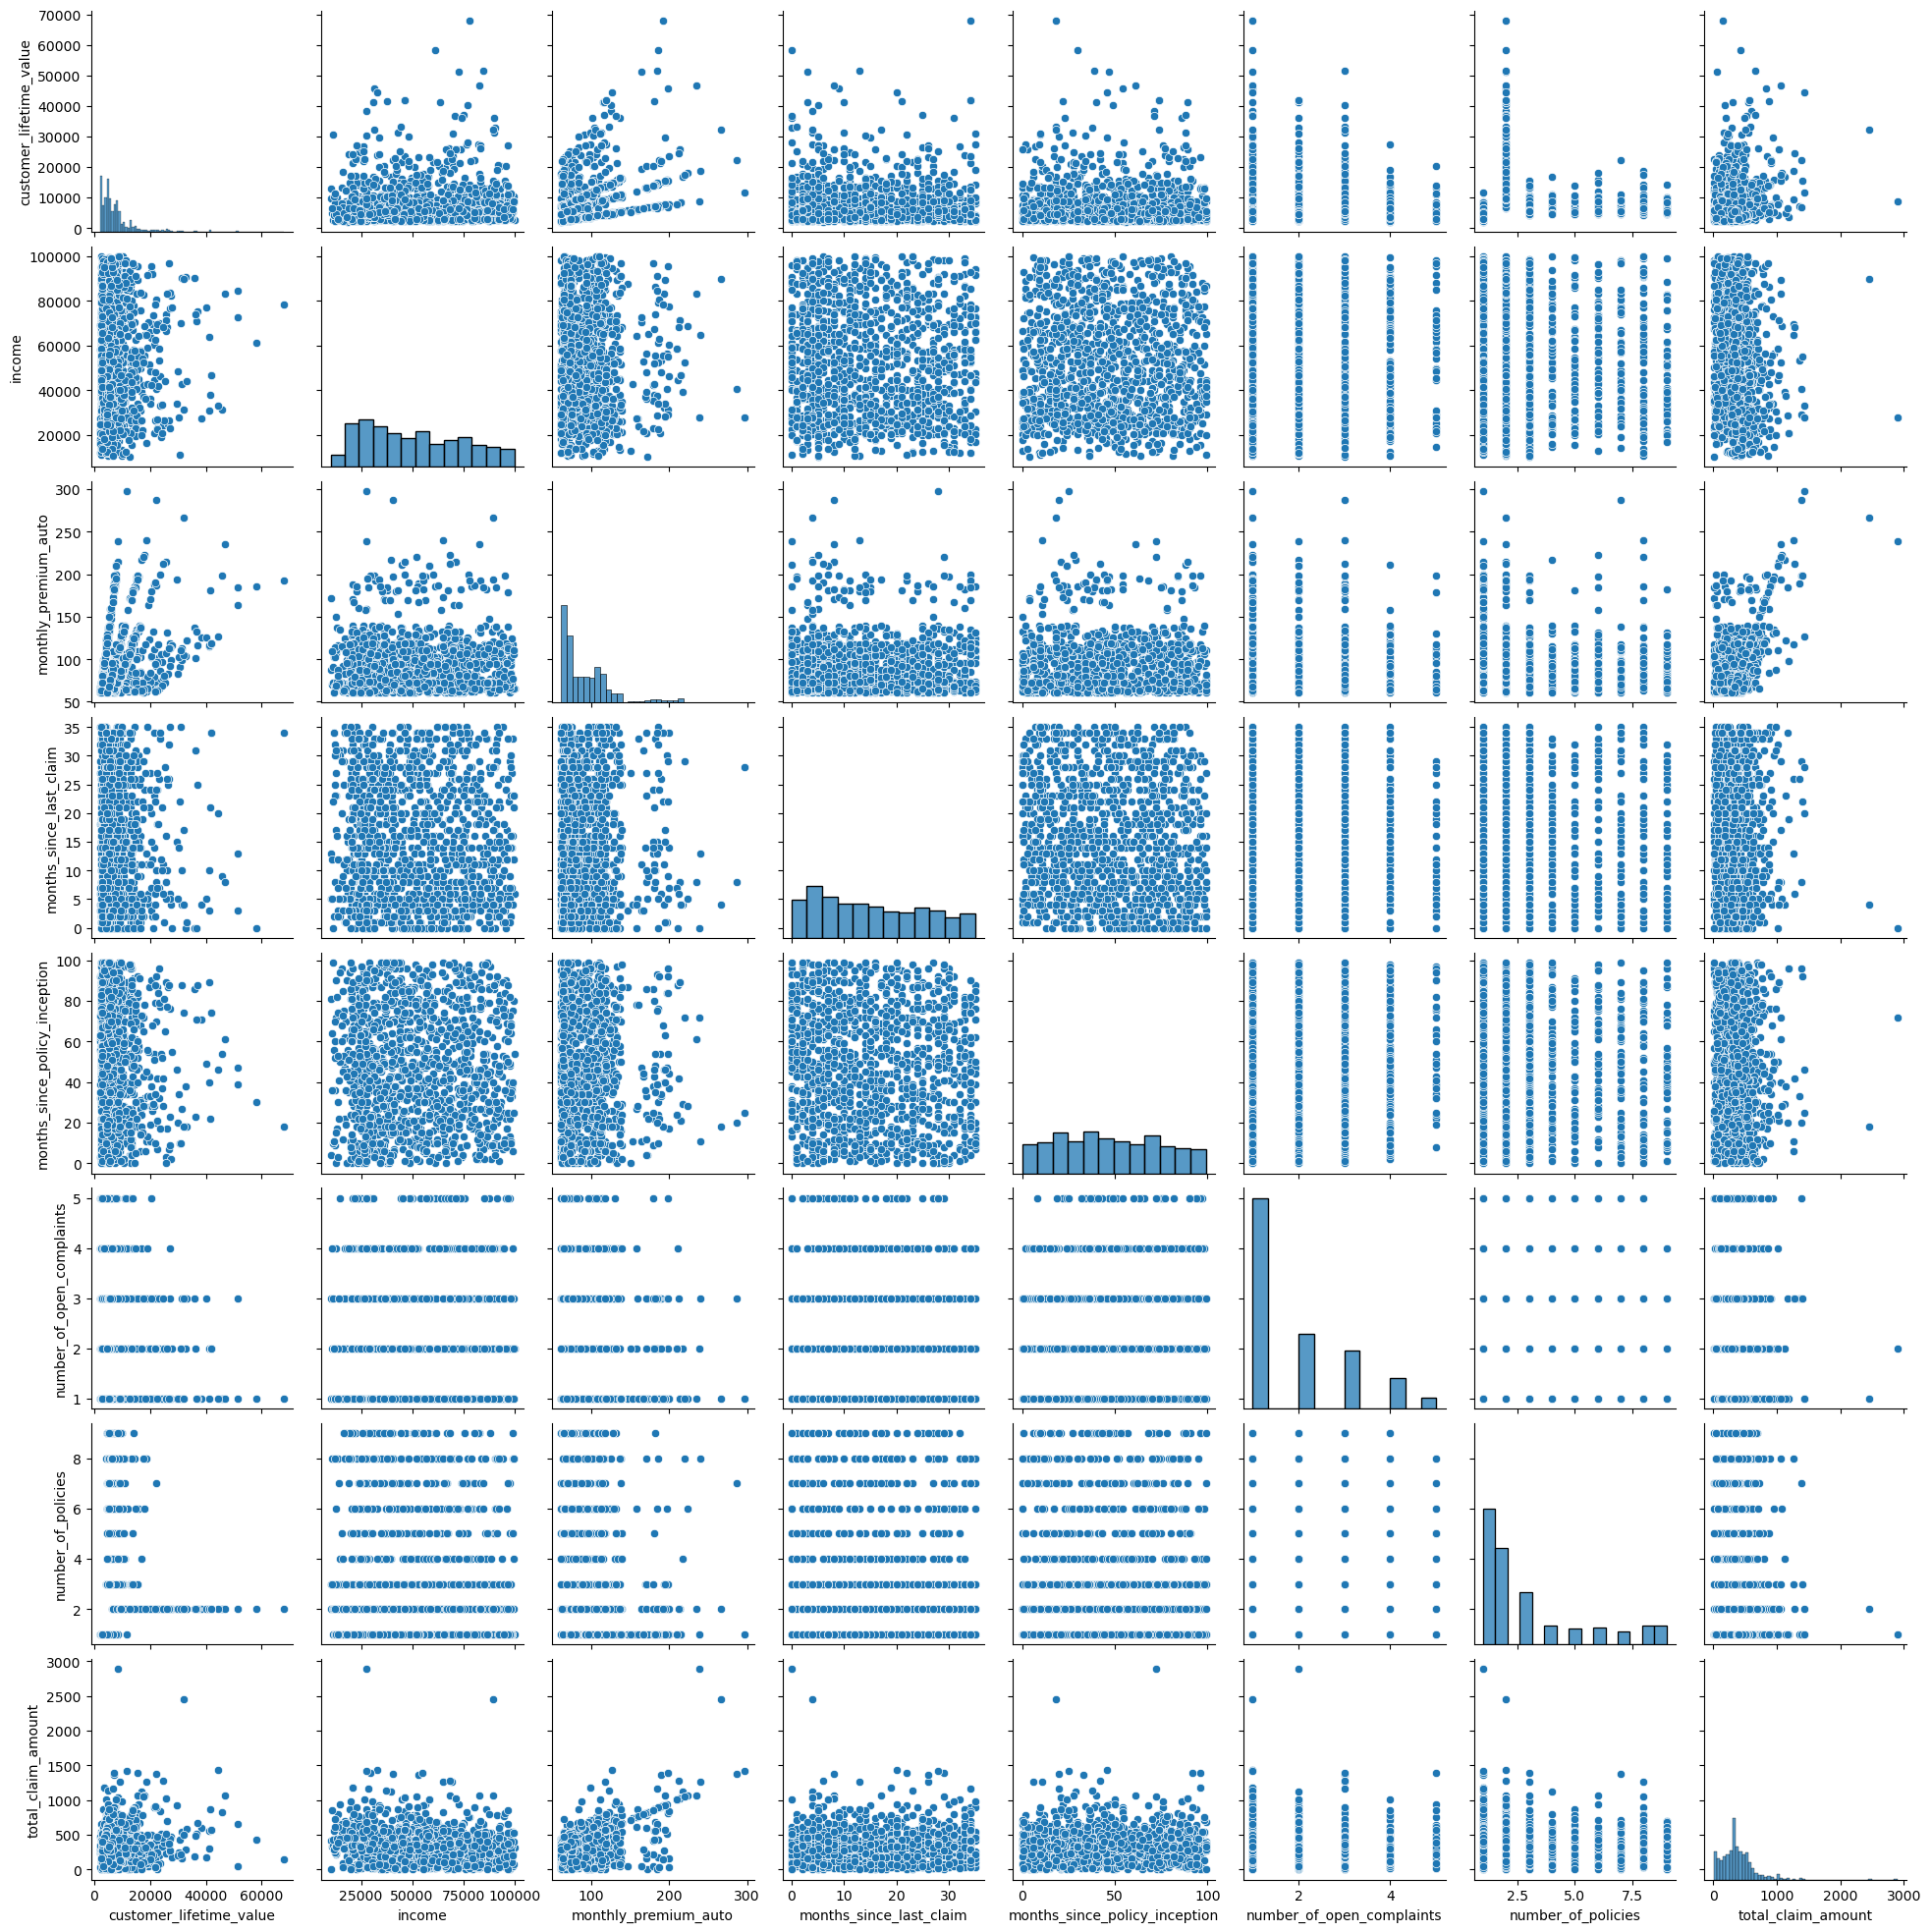

In [39]:
data = cast_column(data) # Cast the dataframe to the suggested dtypes
display(data) # Display the dataframe
display(data.describe()) # Display the summary statistics of the dataframe
correlation_matrix = numerical.corr() # Calculate the correlation matrix
display(correlation_matrix) # Display the correlation matrix 
sns.heatmap(numerical.corr(), annot=True) # Plot the correlation matrix as a heatmap
plt.show() 
sns.pairplot(data.select_dtypes(include=['float64', 'int64'])) # Plot the pairplot of the numerical columns to check for outliers and distributions
plt.show() 

The correlation for numerical values is very low, let's continue processing the data

## 04 - Preprocessing and Feature Engineering (PFE)

### Dealing with outliers.

The correlations were not high, so we'll try to remove insignificant variables / outliers

In [40]:
data.isin([0]).sum() # count amount of 0 values in each column and distribution of numerical columns

coverage                          0
customer                          0
customer_lifetime_value           0
education                         0
effective_to_date                 0
employmentstatus                  0
gender                            0
income                            0
location_code                     0
marital_status                    0
monthly_premium_auto              0
months_since_last_claim          44
months_since_policy_inception    13
number_of_open_complaints         0
number_of_policies                0
policy                            0
policy_type                       0
renew_offer_type                  0
response                          0
sales_channel                     0
state                             0
total_claim_amount                0
vehicle_class                     0
vehicle_size                      0
dtype: int64

In [8]:
# Most of the histograms are skewed to the right. But the outliers are only significant in the 'income' and 'number_of_open_complaints' columns. So let's drop the outliers in those columns.

data = data[data['income'] != 0] # Drop the 0 values in the 'income' column
data = data[data['number_of_open_complaints'] != 0] # Drop the 0 values in the 'number_of_open_complaints' column

numerical2 = data.select_dtypes(include=np.number) # Select numerical columns 
categoricals2 = data.select_dtypes(include=object) # Select categorical columns

In [9]:
# Let's drop the columns that are not relevant for the model by checking the correlation matrix with columns that have a correlation of under 0.1
numericaldropped = numerical2.drop(columns=['number_of_open_complaints', 'number_of_policies', 'months_since_last_claim', 'months_since_policy_inception'])
# This also keeps the columns that are the most linear to the target column ('total_claim_amount')

### Encoding Categorical Data

In [10]:
# One Hot Encoding technique
from sklearn.preprocessing import OneHotEncoder
transformOneHot = OneHotEncoder(drop="first") # Drop the first column to avoid multicollinearity (dummy variable trap)
categoricalsOneHot = pd.DataFrame(transformOneHot.fit_transform(categoricals2).toarray())

# Label Encoding technique
from sklearn.preprocessing import LabelEncoder
transformLabel = categoricals2.apply(LabelEncoder().fit_transform)

# Concatenate the encoded columns with numerical columns
dataNumEncoded = pd.concat([numerical2, categoricalsOneHot], axis=1)

# At this stage, we will not use the Encoding technique because it is not necessary for the Linear Regression model.

### Splitting into train set and test sets

In [11]:
# Time for Linear Regression for the numerical values 

# Separate the target variable from the rest of the data
y = numericaldropped['total_claim_amount']
X = numericaldropped.drop(['total_claim_amount'], axis=1)
# Split the data into train and test sets 
# The test is 20% (or 30%) of the data and the random state is set to 42 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Transformers

The distributions are also not gaussian, so we can try to apply a transformation so our model can work better

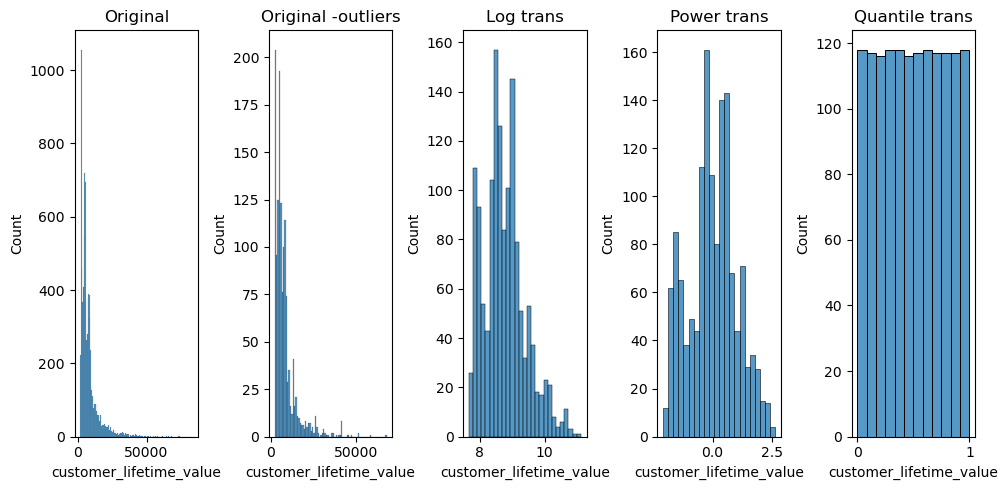

In [27]:
# Log transformation of the numerical columns 
lognumerical2 = numerical2.apply(np.log) # Apply the log transformation to the numerical columns
X_train_transformedLog = np.log(X_train + 1)  # Adding 1 to avoid issues with zero values
X_test_transformedLog = np.log(X_test + 1)  # Adding 1 to avoid issues with zero values

# Power transformation of the numerical columns (Yeo-Johnson)
from sklearn.preprocessing import PowerTransformer
powernumerical2 = PowerTransformer(method='yeo-johnson').fit_transform(numerical2) # Apply the power transformation to the numerical columns
transformerPower = PowerTransformer(method='yeo-johnson')
X_train_transformedPower = transformerPower.fit_transform(X_train)
X_test_transformedPower = transformerPower.transform(X_test)

# Quantile transformation of the numerical columns (Uniform)
from sklearn.preprocessing import QuantileTransformer
quantilenumerical2 = QuantileTransformer(output_distribution='uniform').fit_transform(numerical2) # Apply the quantile transformation to the numerical columns
transformerQuantile = QuantileTransformer(output_distribution='uniform')
X_train_transformedQuantile = transformerQuantile.fit_transform(X_train)
X_test_transformedQuantile = transformerQuantile.transform(X_test)

# Let's check and compare the new scales of the numerical columns, using "customer_lifetime_value" as an example. 
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
ax[0].set_title("Original")
sns.histplot(data=numerical, x=numerical["customer_lifetime_value"], ax=ax[0])
ax[1].set_title("Original -outliers")
sns.histplot(data=numerical2, x=numerical2["customer_lifetime_value"], ax=ax[1])
ax[2].set_title("Log trans")
sns.histplot(data=lognumerical2, x=lognumerical2["customer_lifetime_value"], ax=ax[2])
ax[3].set_title("Power trans")
sns.histplot(data=powernumerical2, x=powernumerical2[:,0], ax=ax[3])
ax[3].set_xlabel("customer_lifetime_value")
ax[4].set_title("Quantile trans")
sns.histplot(data=quantilenumerical2, x=quantilenumerical2[:,0], ax=ax[4])
ax[4].set_xlabel("customer_lifetime_value")
plt.tight_layout()
plt.show()


The power transformation seems to have the distributions that look normal and not skewed

### Normalization 
Let's try normalizing the data to help scale the values for the model 

In [36]:
# Define the scalers
transformMinMax = MinMaxScaler()
transformStandard = StandardScaler()

# Transform the data using the scalers

# Normalize (numerical) with MinMaxScaler
# MinMaxscale = pd.DataFrame(transformMinMax.fit_transform(X_train), columns=X_train.columns)
transformMinMax = MinMaxScaler()
X_train_minmax = transformMinMax.fit_transform(X_train_transformedPower)
X_test_minmax = transformMinMax.transform(X_test_transformedPower)

# Normalize (numerical) with StandardScaler
# Normalizescale = pd.DataFrame(transformStandard.fit_transform(X_train), columns=X_train.columns)
transformStandard = StandardScaler()
X_train_standard = transformStandard.fit_transform(X_train_transformedPower)
X_test_standard = transformStandard.transform(X_test_transformedPower)

## 05 - Modeling
###  Apply model 

In [37]:
# Create the models
model1 = LinearRegression()
model2 = LinearRegression()

# Fit the models
model1.fit(X_train_minmax, y_train)
model2.fit(X_train_standard, y_train)

# Predict the target variable for the train and test sets
y_predictions_train1 = model1.predict(X_train_minmax)
y_predictions_test1 = model1.predict(X_test_minmax)
y_predictions_train2 = model2.predict(X_train_standard)
y_predictions_test2 = model2.predict(X_test_standard)

## 06 - Model Validation
### Evaluate the model with R2, RMSE, MAE, MSE scores 

In [38]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics
# Print the evaluation metrics
print("Evaluation metrics for MinMaxScaler:")
print("R2 train =", r2_score(y_train, y_predictions_train1))
print("R2 test =", r2_score(y_test, y_predictions_test1))
print("RMSE train =", np.sqrt(mean_squared_error(y_train, y_predictions_train1)))
print("RMSE test =", np.sqrt(mean_squared_error(y_test, y_predictions_test1)))
print("MAE train =", mean_absolute_error(y_train, y_predictions_train1))
print("MAE test =", mean_absolute_error(y_test, y_predictions_test1))
print("MSE train =", mean_squared_error(y_train, y_predictions_train1))
print("MSE test =", mean_squared_error(y_test, y_predictions_test1))

print("\nEvaluation metrics for StandardScaler:")
print("R2 train =", r2_score(y_train, y_predictions_train2))
print("R2 test =", r2_score(y_test, y_predictions_test2))
print("RMSE train =", np.sqrt(mean_squared_error(y_train, y_predictions_train2)))
print("RMSE test =", np.sqrt(mean_squared_error(y_test, y_predictions_test2)))
print("MAE train =", mean_absolute_error(y_train, y_predictions_train2))
print("MAE test =", mean_absolute_error(y_test, y_predictions_test2))
print("MSE train =", mean_squared_error(y_train, y_predictions_train2))
print("MSE test =", mean_squared_error(y_test, y_predictions_test2))

# As a reminder, the R2 score is the percentage of the variance in the target variable that is predictable from the data.
# it should be as close to 1 as possible.
# The MAE is the average of the absolute differences between the target variable and the predictions.
# it should be as close to 0 as possible.
# The MSE is the average of the squared differences between the target variable and the predictions.
# it should be as close to 0 as possible.
# The RMSE is the square root of the MSE.
# it should be as close to 0 as possible.

Evaluation metrics for MinMaxScaler:
R2 train = 0.2921590089927737
R2 test = 0.30626427590665806
RMSE train = 216.18269860121367
RMSE test = 191.73070302633042
MAE train = 147.89941356870847
MAE test = 143.90431960796457
MSE train = 46734.959174503194
MSE test = 36760.66248297091

Evaluation metrics for StandardScaler:
R2 train = 0.2921590089927736
R2 test = 0.30626427590665806
RMSE train = 216.1826986012137
RMSE test = 191.73070302633042
MAE train = 147.89941356870847
MAE test = 143.90431960796457
MSE train = 46734.9591745032
MSE test = 36760.66248297091


The scoring that came from the different scalers were very similar, nothing conclusive

## 07 - Reporting
Present results.

The data we have is not enough to make a good prediction model for the total claim amount. Even after cleaning the data, the correlation between the variables is very low. 
More extensive models can be used to predict the total claim amount, such as using the categorial data transformed, and reducing the dimensionality with techniques such as PCA. We can also use decision trees, random forest, that we'll see later in the bootcamp. 